In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from datetime import *
import warnings
import time
plt.style.use('seaborn-white')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# **Feature Engineering 완료된 데이터셋 로드**

In [ ]:
df_svc_target = pd.read_csv('/content/drive/MyDrive/SK_competition/wavve_dataset_feature531.csv')

In [ ]:
df_svc_target.shape

(69145, 531)

In [ ]:
# 결측치 확인
null_check_result = {'column': [],
                     'nullcnt': [],
                     'nullratio': []}

total_rows = len(df_svc_target)
for col in df_svc_target.columns:
    null_cnt = df_svc_target[col].isnull().sum()
    null_ratio = (null_cnt / total_rows) * 100

    null_check_result['column'].append(col)
    null_check_result['nullcnt'].append(null_cnt)
    null_check_result['nullratio'].append(null_ratio)

null_df = pd.DataFrame(null_check_result)
null_df.sort_values(by='nullratio', ascending=False)

In [ ]:
# 결측치 X% 이상인 Feature 제거
many_null_cols = null_df.loc[null_df['nullratio'] >= 100, 'column'].tolist()
df_svc_target.drop(columns=many_null_cols, inplace=True)
many_null_cols

In [ ]:
type_dict = {}
for col in category_cols:
    type_dict[col] = 'object'

In [ ]:
# 추가 생성 컬럼들의 결측치 처리
df_svc_target = df_svc_target.fillna(0)
df_svc_target = df_svc_target.astype(type_dict)

In [ ]:
df_svc_target.shape

(69145, 527)

In [ ]:
# 최종 분석 대상 데이터
df_T = df_svc_target.copy()
df_T.info()
df_T.sample(5)

In [ ]:
# Encoding categorical variables to numeric ones

# Label 컬럼은 직접 변환
print('Repurchase = ', df_T.Repurchase.unique().tolist())
print(df_T.Repurchase.value_counts())
df_T['CHURN'] = np.where(df_T.Repurchase == 'X', 1, 0)   # 재결제('O') -> Churn Negative(0), 미결제('X') -> Churn Positive(1)
print('CHURN = ', df_T.CHURN.unique().tolist())
print(df_T.CHURN.value_counts())

# 이외 컬럼들은 일괄 자동 변환
col_lst = df_T.columns.values.tolist()
col_lst.remove('uno')
for c in col_lst:
    if df_T[c].dtype == 'object':
        print(c)
        lbl = LabelEncoder()
        df_T[c] = lbl.fit_transform(list(df_T[c].values))
df_T.sample(5)

# X, y Dataset 정의

In [ ]:
X = df_T.drop(remove_cols, axis=1)
y = df_T["CHURN"]

In [ ]:
for col in X.columns:
    if col in category_cols:
        X[col] = X[col].astype('int')

In [ ]:
len(X.columns)

523

# **Feature Selection**

### RFE with Permutation Importance

In [ ]:
random_seed = 2222

In [ ]:
!pip install eli5 --quiet

     |████████████████████████████████| 106 kB 5.4 MB/s 


In [ ]:
# permutation importance하려면 category feature는 int로 변경해주고, estimator fit할때 category feature를 인자로 주고 넣어주어야함
for col in X.columns:
    if col in category_cols:
        print(col)
        X[col] = X[col].astype('int')

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from sklearn.preprocessing import Binarizer
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

estimator = LGBMClassifier(random_state=random_seed, metric='binary_logloss', n_estimators=10000)
estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
perm = PermutationImportance(estimator, random_state=random_seed).fit(X_test, y_test)

In [ ]:
perm.feature_importances_[:10]

array([-1.44623617e-04,  7.47704100e-03,  3.81806349e-03,  1.19459108e-02,
        0.00000000e+00,  6.07419192e-04,  9.83440596e-04,  3.39576253e-02,
        2.89247234e-05,  9.80548124e-03])

In [ ]:
# permutation importance result df 생성
perm_result = pd.concat([pd.Series(X.columns.tolist()), pd.Series(perm.feature_importances_)], axis=1)
perm_result.columns = ['feature', 'feature_importance']
perm_result.sort_values(by='feature_importance', ascending=False, inplace=True)

# permutation importance 에서 weight가 낮은 것부터 하나씩 제거하며, 성능확인
all_features = perm_result.feature.tolist()
min_features_to_select = 30
thresholds = np.arange(0.001, 0.51, 0.001)
selected_features = all_features.copy()
rfe_result = []

for n_features in range(len(selected_features), min_features_to_select-1, -1):
    selected_features = all_features[:n_features]
    X_dataset = X.loc[:, selected_features].copy()
    y_dataset = y.copy()

    X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=random_seed)

    estimator = LGBMClassifier(random_state=random_seed, metric='binary_logloss', n_estimators=10000)
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    scores = {'threshold': [], 'f1': [], 'accuracy': [], 'precision': [], 'recall': []}
    
    pred_positive_proba = estimator.predict_proba(X_test)[:, 1].reshape(-1, 1)

    for threshold in thresholds:
        binarizer = Binarizer(threshold=threshold)
        binarizer.fit(pred_positive_proba)
        y_pred = binarizer.transform(pred_positive_proba)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        print(f'threshold : {threshold}, f1 : {f1}, accuracy : {accuracy}, precision : {precision}, recall : {recall}')

        scores['threshold'].append(threshold)
        scores['f1'].append(f1)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(precision)
        scores['recall'].append(recall)

    best_f1_idx = np.array(scores['f1']).argmax()
    best_threshold = np.round(scores['threshold'][best_f1_idx], 3)
    best_f1 = np.round(scores['f1'][best_f1_idx], 4)
    best_accuracy = np.round(scores['accuracy'][best_f1_idx], 4)
    print(f'[result] n_features {n_features} :: f1 score {best_f1} :: accuracy {best_accuracy} :: threshold {best_threshold} :: features {selected_features}')

    rfe_result.append({'n_features' : n_features, 'f1_score': best_f1, 'accuracy': best_accuracy, 'threshold': best_threshold, 'features': selected_features})

import pickle
import datetime

localdate = datetime.datetime.now().strftime('%Y%m%d')
fpath = '/content/drive/MyDrive/SK_competition/PermutationRFEResultWithSMOTE_{}.pickle'.format(localdate)
 
# Save pickle
with open(fpath, "wb") as fw:
    pickle.dump(rfe_result, fw)

### RFE with Permutation Importance 결과 로드

In [ ]:
import pickle

fpath = '/content/drive/MyDrive/SK_competition/PermutationRFEResultWithoutSMOTE_20210728.pickle'

with open(fpath, "rb") as f:
    rfe_result = pickle.load(f)

In [ ]:
# Top 10 F1 scores
sorted([i['f1_score'] for i in rfe_result], reverse=True)[:10]

[0.5527,
 0.5524,
 0.5524,
 0.5524,
 0.5521,
 0.5521,
 0.5519,
 0.5516,
 0.5515,
 0.5515]

In [ ]:
sorted_rfe_result = sorted(rfe_result, key=lambda x: x['f1_score'], reverse=True)

select_idx = 3
best_f1 = sorted_rfe_result[select_idx]['f1_score']
best_accuracy = sorted_rfe_result[select_idx]['accuracy']
best_threshold = sorted_rfe_result[select_idx]['threshold']
best_features = sorted_rfe_result[select_idx]['features']

print(best_threshold, best_f1, best_accuracy, len(best_features))

0.285 0.5524 0.6283 349


### RFE With Feature Importance

In [ ]:
# RFE
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import Binarizer
from collections import Counter
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

selected_features = []
previous_selected_features = []
n_feature_ls = list(range(50, len(X.columns)+1))  # 선택할 feature 개수 리스트
thresholds = np.arange(0.2, 0.41, 0.01)
rfe_result = []

estimator = LGBMClassifier(random_state=random_seed, metric='binary_logloss')
estimator.fit(X, y)

for n_iter, n_feature in enumerate(n_feature_ls):
    print('selecting n_feature : {}'.format(n_feature))
    rfe = RFE(estimator, n_feature)
    fit = rfe.fit(X, y)    
    
    if n_iter > 0:
        previous_selected_features = selected_features

    selected_feature_idices = [idx for idx, v in enumerate(fit.support_) if v]
    selected_features = [name for i, name in enumerate(X.columns) if i in selected_feature_idices]
    print(selected_features)

    if n_iter > 0:
        print('add features : {}'.format(list(set(selected_features) - set(previous_selected_features))))
    
    # RFE를 통해서 selected된 Feature만 추출 후 학습 및 성능 확인
    X_ = X.loc[:, selected_features]
    y_ = y

    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=random_seed)
    smote = SMOTE(random_state=random_seed)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    testor = LGBMClassifier(random_state=random_seed, metric='binary_logloss')
    testor.fit(X_train, y_train)

    scores = {'threshold': [],
                'f1': [],
                'accuracy': []}

    for threshold in thresholds:
        pred_positive_proba = testor.predict_proba(X_test)[:, 1].reshape(-1, 1)
        binarizer = Binarizer(threshold=threshold)
        binarizer.fit(pred_positive_proba)
        y_pred = binarizer.transform(pred_positive_proba)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)

        scores['threshold'].append(threshold)
        scores['f1'].append(f1)
        scores['accuracy'].append(accuracy)

    best_f1_idx = np.array(scores['f1']).argmax()
    best_threshold = np.round(scores['threshold'][best_f1_idx], 2)
    best_f1 = np.round(scores['f1'][best_f1_idx], 4)
    best_accuracy = np.round(scores['accuracy'][best_f1_idx], 4)
    print('[result] threshold {} | f1 {} | accuracy {}'.format(best_threshold, best_f1, best_accuracy))
    print('')
    each_result = {'n_feature': n_feature,
                   'selected_features': selected_features,
                   'best_threshold': best_threshold,
                   'best_f1': best_f1,
                   'best_accuracy': best_accuracy}
    rfe_result.append(each_result)


### PCA

In [ ]:
# PCA n_components별 성능
from sklearn.decomposition import PCA


for n_feature in range(len(X.columns), 29, -1):
    print('selecting n_feature : {}'.format(n_feature))
    pca = PCA(n_components=n_feature)
    X_ = pca.fit_transform(X)
    y_ = y

    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=random_seed)

    estimator = LGBMClassifier(random_state=random_seed, metric='binary_logloss', n_estimators=10000)
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    scores = {'threshold': [],
                'f1': [],
                'accuracy': []}

    for threshold in thresholds:
        pred_positive_proba = estimator.predict_proba(X_test)[:, 1].reshape(-1, 1)
        binarizer = Binarizer(threshold=threshold)
        binarizer.fit(pred_positive_proba)
        y_pred = binarizer.transform(pred_positive_proba)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)

        scores['threshold'].append(threshold)
        scores['f1'].append(f1)
        scores['accuracy'].append(accuracy)

    best_f1_idx = np.array(scores['f1']).argmax()
    best_threshold = np.round(scores['threshold'][best_f1_idx], 2)
    best_f1 = np.round(scores['f1'][best_f1_idx], 4)
    best_accuracy = np.round(scores['accuracy'][best_f1_idx], 4)
    print('[result] threshold {} | f1 {} | accuracy {}'.format(best_threshold, best_f1, best_accuracy))
    print('')

selecting n_feature : 521
[result] threshold 0.26 | f1 0.5399 | accuracy 0.5801

selecting n_feature : 520
[result] threshold 0.25 | f1 0.5405 | accuracy 0.5686

selecting n_feature : 519
[result] threshold 0.25 | f1 0.5385 | accuracy 0.5689

selecting n_feature : 518
[result] threshold 0.26 | f1 0.5395 | accuracy 0.5786

selecting n_feature : 517
[result] threshold 0.26 | f1 0.5385 | accuracy 0.5833

selecting n_feature : 516
[result] threshold 0.25 | f1 0.5385 | accuracy 0.5623

selecting n_feature : 515
[result] threshold 0.26 | f1 0.5406 | accuracy 0.5832

selecting n_feature : 514
[result] threshold 0.25 | f1 0.5396 | accuracy 0.5684

selecting n_feature : 513
[result] threshold 0.27 | f1 0.5392 | accuracy 0.5929

selecting n_feature : 512
[result] threshold 0.27 | f1 0.5383 | accuracy 0.593

selecting n_feature : 511
[result] threshold 0.27 | f1 0.5383 | accuracy 0.593

selecting n_feature : 510
[result] threshold 0.26 | f1 0.5382 | accuracy 0.579

selecting n_feature : 509
[resu

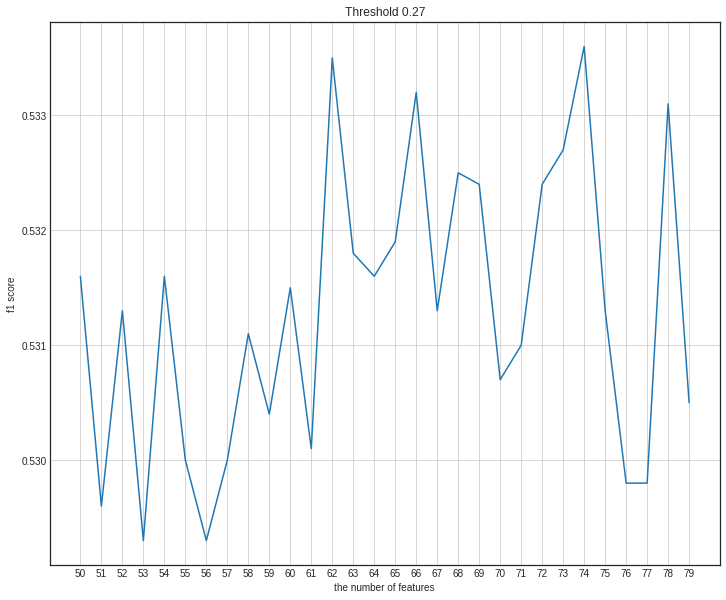

74

In [ ]:
n_features_ls = [i['n_feature'] for i in rfe_result]
f1_scores_ls = [i['best_f1'] for i in rfe_result]

plt.figure(figsize=(12, 10))
plt.plot(n_features_ls, f1_scores_ls)
plt.title('Threshold 0.27')
plt.xlabel('the number of features')
plt.ylabel('f1 score')
plt.xticks(range(min(n_features_ls), max(n_features_ls)+1))
plt.grid()
plt.show()

best_features = sorted(rfe_result, key=lambda x: x['best_f1'], reverse=True)[0]['selected_features']
len(best_features)

# **성능 테스트**

In [ ]:
random_seed = 2222

In [ ]:
X.loc[:, best_features].shape

(69145, 349)

In [ ]:
with open('/content/drive/MyDrive/SK_competition/data/smoted_dataset.pickle', "rb") as fr:
    smoted_df = pickle.load(fr)

In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import Binarizer
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

def custom_score(y_true, y_pred_proba, threshold=0.26):
    y_pos_proba = y_pred_proba[:, 1].reshape(-1, 1)
    binarizer = Binarizer(threshold=threshold)
    y_pred = binarizer.fit_transform(y_pos_proba)
    f1 = metrics.f1_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    f2 = metrics.fbeta_score(y_true, y_pred, beta=2)
    f5 = metrics.fbeta_score(y_true, y_pred, beta=0.5)

    return {'threshold': threshold, 'f1': f1, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc, 'f2': f2, 'f5': f5}

random_seed = 2222

## 학습
threshold_result = []

X_dataset = X.loc[:, best_features].copy()
y_dataset = y.copy()

train_result = []
val_result = []
best_estimators = []
best_thresholds = []
# smoted_df = []

param = {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': -1, 'num_leaves': 31, 'subsample': 0.8}

skfolds = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)

for n_iter, (train_index, val_index) in enumerate(skfolds.split(X_dataset, y_dataset)):
    # X_trn, y_trn = X_dataset.iloc[train_index], y_dataset.iloc[train_index]
    # X_val, y_val = X_dataset.iloc[val_index], y_dataset.iloc[val_index]

    # scaler = StandardScaler()    

    # for col in X_dataset.columns:
    #     if col not in category_cols:
    #         X_trn[col] = scaler.fit_transform(X_trn[col].values.reshape(-1, 1))
    #         X_val[col] = scaler.transform(X_val[col].values.reshape(-1, 1))

    # smote = SMOTE(random_state=random_seed)
    # X_resampled, y_resampled = smote.fit_resample(X_trn, y_trn)
    # X_trn = pd.DataFrame(X_resampled, columns=X_trn.columns)
    # y_trn = pd.Series(y_resampled)

    # smoted_df.append({'X_trn': X_trn, 'y_trn': y_trn, 'X_val': X_val, 'y_val': y_val})

    # best_thresholds = []
    # threshold_ls = []
    # f1_ls = []

    X_trn, y_trn = smoted_df[n_iter]['X_trn'], smoted_df[n_iter]['y_trn']
    X_val, y_val = smoted_df[n_iter]['X_val'], smoted_df[n_iter]['y_val']

    estimator = LGBMClassifier(n_estimators=751, metric='binary_logloss', random_state=random_seed, **param)
    estimator.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    
    for threshold in np.arange(0.01, 0.41, 0.01):    
        val_scores = custom_score(y_val, estimator.predict_proba(X_val), threshold=threshold)
        threshold_ls.append(threshold)
        f1_ls.append(val_scores['f1'])
        
    best_idx = np.argmax(f1_ls)
    best_threshold = threshold_ls[best_idx]
    best_f1 = f1_ls[best_idx]
    print('[best_threshold {:.2f}] best_f1 : {:.4f}'.format(best_threshold, best_f1))

    train_scores = custom_score(y_trn, estimator.predict_proba(X_trn), threshold=0.5)
    val_scores = custom_score(y_val, estimator.predict_proba(X_val), threshold=0.5)

    train_result.append(train_scores['f1'])
    val_result.append(val_scores['f1'])
    best_estimators.append(estimator.best_iteration_)
    best_thresholds.append(best_threshold)
    print('[{} Fold] train f1_score : {:.4f} | validation f1_score : {:.4f} | best_estimators : {}'.format(n_iter, train_scores['f1'], val_scores['f1'], estimator.best_iteration_))
    print('')
# print('\n[result] validation f1_score : {:.4f} | best estimators : {} | best threshold : {}'.format(np.mean(val_result), round(np.mean(best_estimators)), np.round(np.mean(best_thresholds), 2)))
print('\n[result] validation f1_score : {:.4f} | best threshold : {}'.format(np.mean(val_result), np.round(np.mean(best_thresholds), 2)))

[best_threshold 0.29] best_f1 : 0.5450
[0 Fold] train f1_score : 0.7955 | validation f1_score : 0.3865 | best_estimators : None

[best_threshold 0.28] best_f1 : 0.5457
[1 Fold] train f1_score : 0.7942 | validation f1_score : 0.4025 | best_estimators : None

[best_threshold 0.28] best_f1 : 0.5457
[2 Fold] train f1_score : 0.7958 | validation f1_score : 0.3954 | best_estimators : None

[best_threshold 0.28] best_f1 : 0.5457
[3 Fold] train f1_score : 0.7961 | validation f1_score : 0.3971 | best_estimators : None

[best_threshold 0.28] best_f1 : 0.5457
[4 Fold] train f1_score : 0.7957 | validation f1_score : 0.3926 | best_estimators : None


[result] validation f1_score : 0.3948 | best threshold : 0.28


In [ ]:
import pickle

fpath = '/content/drive/MyDrive/SK_competition/data/smoted_dataset.pickle'

with open(fpath, "wb") as fw:
    pickle.dump(smoted_df, fw)

In [ ]:
with open('/content/drive/MyDrive/SK_competition/data/smoted_dataset.pickle', "rb") as fr:
    smoted_df = pickle.load(fr)

# **하이퍼파라미터 튜닝**

### Bayesian Optimazing

In [ ]:
!pip install bayesian-optimization --quiet

In [ ]:
# Bayesian Optimazing
import lightgbm as lgbm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

random_seed = 2222
X_dataset = X.loc[:, best_features].copy()
y_dataset = y.copy()
# X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=random_seed)


#목적함수 생성
def lgbm_cv(learning_rate, num_leaves, max_depth, colsample_bytree, subsample):
    model = lgbm.LGBMClassifier(learning_rate=max(min(learning_rate, 1), 0),
                                num_leaves=int(round(num_leaves)),
                                max_depth=int(round(max_depth)),
                                subsample=max(min(subsample, 1), 0),
                                colsample_bytree=max(min(colsample_bytree, 1), 0))
    scoring = {'f1_score': metrics.make_scorer(metrics.f1_score)}
    result = cross_validate(model, X_dataset, y_dataset, cv=5, scoring=scoring)
    f1_score = result["test_f1_score"].mean()
    return f1_score

In [ ]:
# 입력값의 탐색 대상 구간
pbounds = {'learning_rate': (0.01, 0.1),
            'num_leaves': (24, 80),
            'max_depth': (5, 30),
            'subsample': (0.5, 0.99),
            'colsample_bytree': (0.5, 0.99)}

In [ ]:
#객체 생성
lgbmBO = BayesianOptimization(f=lgbm_cv, pbounds=pbounds, verbose=2, random_state=random_seed)

In [ ]:
# 반복적으로 베이지안 최적화 수행
# acq='ei'사용
# xi=0.01 로 exploration의 강도를 조금 높임
lgbmBO.maximize(init_points=5, n_iter=100, acq='ei', xi=0.01)

|   iter    |  target   | colsam... | learni... | max_depth | num_le... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.3278   |  0.8563   |  0.03601  |  26.24    |  64.72    |  0.6026   |
|  2        |  0.3589   |  0.8089   |  0.08907  |  26.43    |  79.55    |  0.6266   |
|  3        |  0.3362   |  0.5188   |  0.04475  |  21.4     |  68.27    |  0.6958   |
|  4        |  0.2182   |  0.8539   |  0.01328  |  16.75    |  77.37    |  0.9436   |
|  5        |  0.3547   |  0.6811   |  0.08509  |  12.23    |  54.52    |  0.7965   |
|  6        |  0.3597   |  0.6203   |  0.08213  |  29.05    |  79.11    |  0.7076   |
|  7        |  0.3419   |  0.5      |  0.1      |  5.0      |  24.0     |  0.5      |
|  8        |  0.3462   |  0.5      |  0.1      |  30.0     |  24.0     |  0.5      |
|  9        |  0.3541   |  0.5      |  0.1      |  16.58    |  37.24    |  0.5      |
|  10       |  0.3451   |  0.99     |  0.1      |  17.

KeyboardInterrupt: ignored

In [ ]:
# 찾은 파라미터 값 확인
lgbmBO.max

In [ ]:
# optimizer.res[-5:] # 이전 history 를 확인 할 수 있다. 이전에서 특정 pbound의 변화에 따라 최적화 되는 양상을 보고 다시 bound를 줄여서 셋팅 후 최적화 반복

# Changing bounds
lgbmBO.set_bounds(new_bounds={"max_depth": (20, 60),
                                 'num_leaves': (300, 1000)})

lgbmBO.maximize(init_points=5, n_iter=50)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  56       |  0.3625   |  0.8705   |  0.7428   |  0.2057   |  0.1131   |  0.6905   |  38.03    |  47.26    |  472.8    |  0.9052   |
|  57       |  0.3855   |  0.8616   |  0.8341   |  0.4421   |  0.5743   |  0.4238   |  46.85    |  27.16    |  997.0    |  0.8241   |
|  58       |  0.3847   |  0.8326   |  0.6088   |  0.473    |  0.7607   |  0.2841   |  40.48    |  41.56    |  811.6    |  0.7064   |
|  59       |  0.3825   |  0.811    |  0.9757   |  0.7365   |  0.2412   |  0.8407   |  26.62    |  53.12    |  939.2    |  0.9592   |
|  60       |  0.3478   |  0.8162   |  0.7782   |  0.1791   |  0.4136   |  0.8131   |  21.32    |  78.71    |  733.6    |  0.6428   |
|  61       |  0.3709   |  0.8127   |  0.8284   |  0.2463   | 

### Grid Search

In [ ]:
random_seed = 2222

In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
from sklearn.preprocessing import Binarizer
import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

In [ ]:
from itertools import product

lgbm_params = {'learning_rate': [0.1],
               'subsample': [1],  # default 1(**)
              'colsample_bytree': [1],  # default 1(**)
               'num_leaves': [31],  # default 31(*),
               'max_depth': [30]  # default -1(***)
          }

def get_total_combinations_num(params):
    total_params = 1
    for i in params.values():
        total_params *= len(i)
    return total_params

def lgbm_params_combination(params):
    hparam_ls = [params[i] for i in params.keys()]
    combinations = list(product(*hparam_ls))
    
    for combi in combinations:
        result = {}
        result['learning_rate'] = combi[0]
        result['subsample'] = combi[1]
        result['colsample_bytree'] = combi[2]
        result['num_leaves'] = combi[3]
        result['max_depth'] = combi[4]
        
        yield result

def get_best_history(fit_history):
    return fit_history[np.array([i['f1'] for i in fit_history]).argmax()]

In [ ]:
X_dataset = X.loc[:, best_features].copy()
y_dataset = y.copy()

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=random_seed)

In [ ]:
X_train.shape, X_test.shape

((55316, 478), (13829, 478))

In [ ]:
# SMOTE 적용
smote = SMOTE(random_state=random_seed)
X_sampled, y_sampled = smote.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_sampled, columns=X_train.columns)
y_train = pd.Series(y_sampled)

In [ ]:
X_train.shape, y_train.shape

((75906, 478), (75906,))

In [ ]:
fit_history = []
processing_t_history = []
total_params = get_total_combinations_num(lgbm_params)
selected_params = lgbm_params_combination(lgbm_params)
thresholds = np.arange(0.01, 0.501, 0.001)

for n_iter, param in enumerate(selected_params):
    s_t = time.time()
    print('[{} / {}]'.format(n_iter+1, total_params))
    print('[param] {}'.format(param))

    estimator = LGBMClassifier(random_state=random_seed, metric='binary_logloss', n_estimators=10000, **param)
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    scores = {'threshold': [],
                'f1': [],
                'accuracy': []}

    pred_positive_proba = estimator.predict_proba(X_test)[:, 1].reshape(-1, 1)

    for threshold in thresholds:
        binarizer = Binarizer(threshold=threshold)
        binarizer.fit(pred_positive_proba)
        y_pred = binarizer.transform(pred_positive_proba)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)

        scores['threshold'].append(threshold)
        scores['f1'].append(f1)
        scores['accuracy'].append(accuracy)

    best_f1_idx = np.array(scores['f1']).argmax()
    best_threshold = np.round(scores['threshold'][best_f1_idx], 3)
    best_f1 = np.round(scores['f1'][best_f1_idx], 4)
    best_accuracy = np.round(scores['accuracy'][best_f1_idx], 4)

    each_history = {}
    each_history['parameter'] = param
    each_history['best_estimators'] = estimator.best_iteration_
    each_history['threshold'] = best_threshold
    each_history['f1'] = best_f1
    each_history['accuracy'] = best_accuracy
    fit_history.append(each_history)
    e_t = time.time()
    processing_t = e_t - s_t
    print('[result] best_estimators {} | threshold {} | f1 {} | accuracy {}'.format(estimator.best_iteration_, best_threshold, best_f1, best_accuracy))
    print('[Processing time] {:.3f} s'.format(processing_t))
    if (n_iter + 1) % 10 == 0:
        print('[best] {}'.format(get_best_history(fit_history)))
    print('')
    processing_t_history.append(processing_t)
print('Total Processing Time {:.3f} s'.format(sum(processing_t_history)))


[1 / 1]
[param] {'learning_rate': 0.1, 'subsample': 1, 'colsample_bytree': 1, 'num_leaves': 31, 'max_depth': 30}
[result] best_estimators 86 | threshold 0.279 | f1 0.5552 | accuracy 0.6138
[Processing time] 14.493 s

Total Processing Time 14.493 s


In [ ]:
def get_best_history(fit_history, top=1):
    if top == 1:
        return fit_history[np.array([i['f1'] for i in fit_history]).argmax()]
    else:
        return sorted(fit_history, key=lambda x: x['f1'], reverse=True)[:top]

get_best_history(fit_history, top=10)

In [ ]:
plot_importance(estimator, figsize=(16,10))

### Random Search

In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Binarizer
import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

X_dataset = X.loc[:, bestfeatures]
y_dataset = y

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=random_seed)

smote = SMOTE(random_state=random_seed)
X_train, y_train = smote.fit_resample(X_train, y_train)

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'binary_logloss', 
             "eval_set" : [(X_train, y_train)],
             'eval_names': ['test'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7, 10, 20, 40, 100],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_iter = 1000

def custom_scoring(y_test, y_pred):
    

estimator = LGBMClassifier(random_state=random_seed, metric='binary_logloss')
random_search = RandomizedSearchCV(
    estimator=estimator, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='f1',
    cv=5,
    refit=True,
    random_state=random_seed,
    verbose=2
    )

random_search.fit(X_train, y_train, **fit_params)
opt_parameters = random_search.best_params_

print('')
print('best hparam :', opt_parameters)
print('best f1 score:', random_search.best_score_)
print('')

# Predicting y_test
estimator = LGBMClassifier(random_state=random_seed, metric='binary_logloss', **opt_parameters)
estimator.fit(X_train, y_train)

thresholds = np.arange(0., 0.51, 0.01)

for threshold in thresholds:
    pred_positive_proba = estimator.predict_proba(X_test)[:, 1].reshape(-1, 1)
    binarizer = Binarizer(threshold=threshold)
    binarizer.fit(pred_positive_proba)
    y_pred = binarizer.transform(pred_positive_proba)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    print('[result] threshold {:.2f} | f1 {:.4f} | accuracy {:.4f} | precision {:.4f} | recall {:.4f}'.format(threshold, f1, accuracy, precision, recall))
print('')

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### 기타 실험(Deep Learning)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
random_seed = 777

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
## train data
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## test data    
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = testData(torch.FloatTensor(X_test))

In [ ]:
learning_rate = 0.005
batch_size = 64
epochs = 50

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
X_train.shape

(55316, 521)

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self): #
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(521, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layer(x)

In [ ]:
model = LinearClassifier().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
loss_history = []

model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    average_loss = epoch_loss/len(train_loader)
    loss_history.append(average_loss)
    print(f'Epoch {e+0:03}: | Loss: {average_loss:.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.61004 | Acc: 68.910
Epoch 002: | Loss: 0.58848 | Acc: 70.168
Epoch 003: | Loss: 0.58161 | Acc: 70.664
Epoch 004: | Loss: 0.57852 | Acc: 70.793
Epoch 005: | Loss: 0.57489 | Acc: 70.936
Epoch 006: | Loss: 0.57117 | Acc: 71.185
Epoch 007: | Loss: 0.56781 | Acc: 71.373
Epoch 008: | Loss: 0.56632 | Acc: 71.476
Epoch 009: | Loss: 0.56397 | Acc: 71.466
Epoch 010: | Loss: 0.56094 | Acc: 71.558
Epoch 011: | Loss: 0.55690 | Acc: 72.022
Epoch 012: | Loss: 0.55376 | Acc: 72.118
Epoch 013: | Loss: 0.54940 | Acc: 72.170
Epoch 014: | Loss: 0.54482 | Acc: 72.462
Epoch 015: | Loss: 0.53862 | Acc: 72.665
Epoch 016: | Loss: 0.53487 | Acc: 72.802
Epoch 017: | Loss: 0.52719 | Acc: 73.383
Epoch 018: | Loss: 0.52180 | Acc: 73.516
Epoch 019: | Loss: 0.51389 | Acc: 73.871
Epoch 020: | Loss: 0.50698 | Acc: 74.331
Epoch 021: | Loss: 0.50127 | Acc: 74.513
Epoch 022: | Loss: 0.48912 | Acc: 75.260
Epoch 023: | Loss: 0.48510 | Acc: 75.634
Epoch 024: | Loss: 0.47547 | Acc: 76.029
Epoch 025: | Los

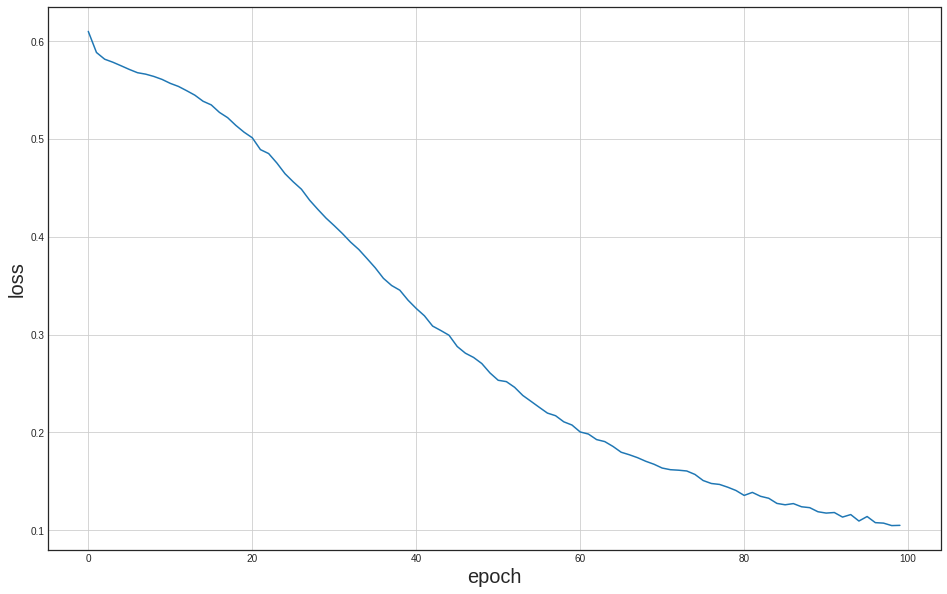

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(range(epochs), loss_history)
plt.grid()
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

In [ ]:
from sklearn import metrics

thresholds = np.arange(0.2, 0.51, 0.01)

model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        # y_pred_tag = torch.round(y_test_pred)
        y_pred_tag = torch.where(y_test_pred >= 0.4, 1, 0)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
# y_pred = np.array(y_pred_list).reshape(-1, 1)
print(metrics.f1_score(y_test, y_pred_list))
print(metrics.accuracy_score(y_test, y_pred_list))
print('')

0.40972986187507643
0.6508062766649794



In [ ]:
## 평가
for threshold in thresholds:
    pred_positive_proba = y_pred
    binarizer = Binarizer(threshold=threshold)
    binarizer.fit(pred_positive_proba)
    y_pred = binarizer.transform(pred_positive_proba)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    print('[result] threshold {:.2f} | f1 {:.4f} | accuracy {:.4f}'.format(threshold, f1, accuracy))

[result] threshold 0.20 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.21 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.22 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.23 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.24 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.25 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.26 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.27 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.28 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.29 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.30 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.31 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.32 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.33 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.34 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.35 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.36 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.37 | f1 0.5000 | accuracy 0.6109
[result] threshold 0.38 | f1

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[5758, 3747],
       [1634, 2690]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.61      0.68      9505
           1       0.42      0.62      0.50      4324

    accuracy                           0.61     13829
   macro avg       0.60      0.61      0.59     13829
weighted avg       0.67      0.61      0.62     13829



In [ ]:
model.eval()

y_pred = model(X_test)
y_pred

# 예측

In [ ]:
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': -1, 'num_leaves': 31, 'subsample': 0.8}
best_estimators = 751
best_threshold = 0.22
trial = 20

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

random_seed = 2222

X_dataset = X.loc[:, best_features].copy()
y_dataset = y.copy()
print(y_dataset.value_counts())

scaler = StandardScaler()

for col in X_dataset.columns:
    if col not in category_cols:
        X_dataset[col] = scaler.fit_transform(X_dataset[col].values.reshape(-1, 1)) 
        X_predict[col] = scaler.transform(X_predict[col].values.reshape(-1, 1)) 

smote = SMOTE(random_state=random_seed)
X_sampled, y_sampled = smote.fit_resample(X_dataset, y_dataset)
X_train = pd.DataFrame(X_sampled, columns=X_dataset.columns)
y_train = pd.Series(y_sampled)
print(y_train.value_counts())

estimator = LGBMClassifier(metric='binary_logloss', n_estimators=best_estimators, random_state=random_seed, **best_params)
estimator.fit(X_train, y_train)

0    47352
1    21793
Name: CHURN, dtype: int64
1    47352
0    47352
dtype: int64


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.02, max_depth=-1,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=751,
               n_jobs=-1, num_leaves=31, objective=None, random_state=2222,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)